In [1]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import torch
from IPython.display import display
from ultralytics import YOLO
from pathlib import Path
from PIL import Image, ImageFilter, ImageChops

## <font face = "Century Gothic">**Recolección de Datos**</font>

### <font face = "Century Gothic">**Archivo YAML de Configuración**</font>
##### <font face = "Century Gothic">**Definición**</font>

<font face = "Century Gothic" size="3"> Un archivo YAML (YAML Ain't Markup Language) se utiliza para representar datos estructurados en un formato legible para los humanos. Los archivos YAML suelen emplearse para configuraciones y representación de datos en muchos proyectos, especialmente en machine learning, DevOps y scripts de automatización.</font>

##### <font face = "Century Gothic">**Estructura**</font>

```yaml
train: train\images # ruta del directorio con las imágenes de entrenamiento
val: valid\images # ruta del directorio con las imágenes de validación 
test: test\images # ruta del directorio con las imágenes de prueba
```
<li><font face = "Century Gothic" size="3">Definen las rutas locales donde se encuentran las imágenes para cada conjunto de datos (entrenamiento, validación y prueba).</font></li>
  <ul>
   <li><p><code>train</code>:<font face = "Century Gothic" size="3"> Directorio con las imágenes de entrenamiento.</font></p></li>
   <li><p><code>val</code>:<font face = "Century Gothic" size="3"> Directorio con las imágenes de validación.</font></p></li>
   <li><p><code>test</code>: <font face = "Century Gothic" size="3"> Directorio con las imágenes de prueba.</font></p></li>
  </ul>

```yaml 
nc: 7 # definición del número de clases
```
<li><font face = "Century Gothic" size="3">Es el número de clases que el modelo debe reconocer. Aquí 7 indica que se tienen 7 categorías diferentes para identificar.</font></li>

```yaml
names: ['Bacterial Spot', 'Early_Blight', 'Healthy', 'Late_blight', 'Leaf Mold', 'Target_Spot', 'black spot']
```
  <li><font face = "Century Gothic" size="3">Lista que contiene los nombres de las clases correspondientes al índice de cada categoría. El orden es importante, ya que se usa para etiquetar las predicciones y entrenar el modelo.</font></li>
  <ul>
      <li><p><code>0</code>:<font face = "Century Gothic" size="3"> Bacterial Spot (mancha bacteriana)</font></p></li>
      <li><p><code>1</code>:<font face = "Century Gothic" size="3"> Early Blight (tizón temprano)</font></p></li>
      <li><p><code>2</code>: <font face = "Century Gothic" size="3"> Healthy (saludable)</font></p></li>
      <li><p><code>3</code>:<font face = "Century Gothic" size="3"> Late Blight (tizón tardio)</font></p></li>
      <li><p><code>4</code>:<font face = "Century Gothic" size="3"> Leaf Mold (molde de hoja)</font></p></li>
      <li><p><code>5</code>: <font face = "Century Gothic" size="3"> Target Spot (punto objetivo)</font></p></li>
      <li><p><code>6</code>: <font face = "Century Gothic" size="3"> Black Spot (punto negro)</font></p></li>
  </ul>

In [2]:
os.chdir('..')

In [3]:
# define la ruta del archivo YAML
data_yaml_path = "tomato_diseases_detection/data.yaml"

try:
    # abrir el archivo YAML en modo de lectura
    with open(data_yaml_path, 'r') as file:
        # cargar el contenido del archivo utilizando la función safe_load de yaml
        data_yaml = yaml.safe_load(file)
except FileNotFoundError:
    # capturar el error si el archivo no se encuentra y muestra un mensaje de error
    print(f"Error: El archivo '{data_yaml_path}' no fue encontrado.")
except yaml.YAMLError as e:
    # capturar errores relacionados con el formato YAML y muestra un mensaje de error
    print(f"Error al procesar el archivo YAML: {e}")
except Exception as e:
    # capturar cualquier otro error no previsto y lo muestra
    print(f"Ha ocurrido un error inesperado: {e}")
else:
    # si no hay errores, muestra que el archivo YAML se cargó correctamente
    print("Archivo YAML cargado exitosamente.")

Archivo YAML cargado exitosamente.


In [4]:
# definir la ruta para el conjunto de entrenamiento, validación y prueba
train_path = "tomato_diseases_detection/datasets/train/images"  # ruta donde se almacenan las imágenes de entrenamiento
val_path = "tomato_diseases_detection/datasets/valid/images"    # ruta donde se almacenan las imágenes de validación
test_path = "tomato_diseases_detection/datasets/test/images"    # ruta donde se almacenan las imágenes de prueba

# obtener el número de clases ('nc') del archivo YAML
nc = data_yaml['nc'] 

# obtener los nombres de las clases desde el archivo YAML
class_names = data_yaml['names'] 

## <font face = "Century Gothic">**Análisis de los Datos**</font>

### <font face = "Century Gothic">**Análisis de Datos Faltantes**</font>

In [5]:
def count_total_files(path):
    """
    Cuenta la cantidad total de archivos .txt en un directorio específico
    
    Parámetros:
    path (str): Ruta del directorio donde se encuentran los archivos de texto

    Retorna:
    int: La cantidad total de archivos
    """
    total_files = len(list(Path(path).glob('*.txt')))
    print(f"Total de archivos en {path}: {total_files}")
    return total_files

In [6]:
# contar archivos totales
total_train_files = count_total_files(train_path.replace('images', 'labels'))
total_val_files = count_total_files(val_path.replace('images', 'labels'))
total_test_files = count_total_files(test_path.replace('images', 'labels'))

Total de archivos en tomato_diseases_detection/datasets/train/labels: 645
Total de archivos en tomato_diseases_detection/datasets/valid/labels: 61
Total de archivos en tomato_diseases_detection/datasets/test/labels: 31


In [7]:
def count_empty_files(path):
    """
    Cuenta la cantidad de archivos .txt vacíos en un directorio específico
    
    Parámetros:
    path (str): Ruta del directorio donde se encuentran los archivos de texto

    Retorna:
    int: La cantidad de archivos vacíos
    """
    empty_files_count = 0
    files = list(Path(path).glob('*.txt'))
    if len(files) == 0:
        print(f"No se encontraron archivos .txt en la ruta: {path}")
    for label_file in files:
        with open(label_file, 'r') as file:
            lines = file.readlines()
            if len(lines) == 0:  # si el archivo está vacío
                empty_files_count += 1
    print(f"Cantidad de archivos vacíos en {path}: {empty_files_count}")
    return empty_files_count

In [8]:
def count_non_empty_files(path):
    """
    Cuenta la cantidad de archivos .txt no vacíos en un directorio específico
    
    Parámetros:
    path (str): Ruta del directorio donde se encuentran los archivos de texto

    Retorna:
    int: La cantidad de archivos no vacíos
    """
    non_empty_files_count = 0
    files = list(Path(path).glob('*.txt'))
    if len(files) == 0:
        print(f"No se encontraron archivos .txt en la ruta: {path}")
    for label_file in files:
        with open(label_file, 'r') as file:
            lines = file.readlines()
            if len(lines) > 0:  # si el archivo no está vacío
                non_empty_files_count += 1
    print(f"Cantidad de archivos no vacíos en {path}: {non_empty_files_count}")
    return non_empty_files_count

In [9]:
# contar archivos vacíos
train_empty_count = count_empty_files(train_path.replace('images', 'labels'))
val_empty_count = count_empty_files(val_path.replace('images', 'labels'))
test_empty_count = count_empty_files(test_path.replace('images', 'labels'))

# contar archivos no vacíos
train_non_empty_count = count_non_empty_files(train_path.replace('images', 'labels'))
val_non_empty_count = count_non_empty_files(val_path.replace('images', 'labels'))
test_non_empty_count = count_non_empty_files(test_path.replace('images', 'labels'))

Cantidad de archivos vacíos en tomato_diseases_detection/datasets/train/labels: 18
Cantidad de archivos vacíos en tomato_diseases_detection/datasets/valid/labels: 2
Cantidad de archivos vacíos en tomato_diseases_detection/datasets/test/labels: 0
Cantidad de archivos no vacíos en tomato_diseases_detection/datasets/train/labels: 627
Cantidad de archivos no vacíos en tomato_diseases_detection/datasets/valid/labels: 59
Cantidad de archivos no vacíos en tomato_diseases_detection/datasets/test/labels: 31


In [10]:
def plot_data_summary(non_empty_counts, empty_counts, labels):
    # crear la figura y los ejes
    fig, ax = plt.subplots()

    # paleta de colores 
    colors = ['#606c38', '#52796f']

    # posición de las barras en el gráfico
    x = np.arange(len(labels))
    bar_width = 0.35

    # graficar barras de no vacíos y vacíos
    bars1 = ax.bar(x - bar_width / 2, non_empty_counts, width=bar_width, label='Archivos no vacíos', color=colors[0])
    bars2 = ax.bar(x + bar_width / 2, empty_counts, width=bar_width, label='Archivos vacíos', color=colors[1])

    # añadir etiquetas y título
    ax.set_ylabel('Cantidad de archivos')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    # añadir valores encima de cada barra
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

    # añadir leyenda
    ax.legend()

    # mostrar el gráfico
    plt.show()

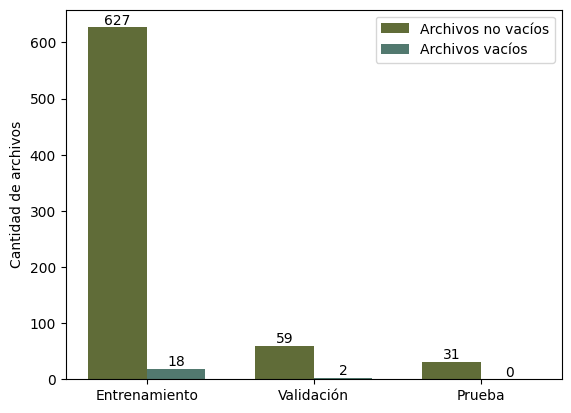

In [11]:
# datos para graficar
empty_counts = [train_empty_count, val_empty_count, test_empty_count]
non_empty_counts = [train_non_empty_count, val_non_empty_count, test_non_empty_count]
labels = ['Entrenamiento', 'Validación', 'Prueba']

# llamar a la función para graficar
plot_data_summary(non_empty_counts, empty_counts, labels)

### <font face = "Century Gothic">**Análisis de Diversidad de Clases**</font>

In [12]:
def load_labels(path):
    """
    Carga las etiquetas desde los archivos .txt en un directorio específico
    
    Parámetros:
    path (str): Ruta del directorio donde se encuentran los archivos de texto

    Retorna:
    list: Una lista de enteros, donde cada entero representa la primera columna de cada línea en los archivos de texto
    """
    # lista vacía para almacenar las etiquetas
    labels = []
    for label_file in Path(path).glob('*.txt'):
        # abrir cada archivo de texto encontrado en modo lectura
        with open(label_file, 'r') as file:
            for line in file:
                # dividir la línea en palabras o elementos utilizando espacios en blanco como separador
                # tomar el primer elemento de la línea (posición[0]) y convertir a entero y añadir a la lista 'labels'
                labels.append(int(line.split()[0]))
    # retornar la lista 'labels' con las etiquetas extraídas
    return labels

In [13]:
# cargar etiquetas de entrenamiento 
train_labels = load_labels(train_path.replace('images', 'labels'))
# cargar etiquetas de validación 
val_labels = load_labels(val_path.replace('images', 'labels'))
# cargar etiquetas de prueba
test_labels = load_labels(test_path.replace('images', 'labels'))

In [14]:
# combinar las etiquetas de los conjuntos de entrenamiento, validación y prueba en una sola lista
labels = train_labels + val_labels + test_labels
# contar la frecuencia de cada etiqueta en la lista combinada, ordena los valores por clase
labels_count = pd.Series(labels).value_counts().sort_index()
# reemplazar los índices de las etiquetas numéricas por los nombres de las clases correspondientes
labels_count.index = [class_names[i] for i in labels_count.index]

In [15]:
def plot_class_distribution(labels_count):
    """
    Crea un gráfico de barras para mostrar la distribución de clases, utilizando colores personalizados
    y agregando los valores encima de cada barra

    Parámetros:
    labels_count (list o array-like): Lista o array con los valores que representan la cantidad de instancias por clase
    """

    # paleta de colores
    colors = ['#84a98c', '#52796f', '#cad2c5'] 

    # obtener las clases (índices) y los conteos de cada clase
    classes = labels_count.index
    counts = labels_count.values

    # crear el gráfico de barras
    fig, ax = plt.subplots(figsize=(10, 6))  # establecer el tamaño del gráfico
    bars = ax.bar(classes, counts, color=colors[:len(classes)])  # crear las barras

    # añadir etiquetas a los ejes y el título
    ax.set_ylabel('Cantidad de Etiquetas')  # etiqueta del eje Y
    ax.set_xlabel('Clase')  # etiqueta del eje X

    # añadir los valores (conteos) sobre las barras
    for bar in bars:
        yval = bar.get_height()  # obtener la altura de cada barra
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')  # colocar el texto sobre la barra

    # mostrar el gráfico
    plt.show()

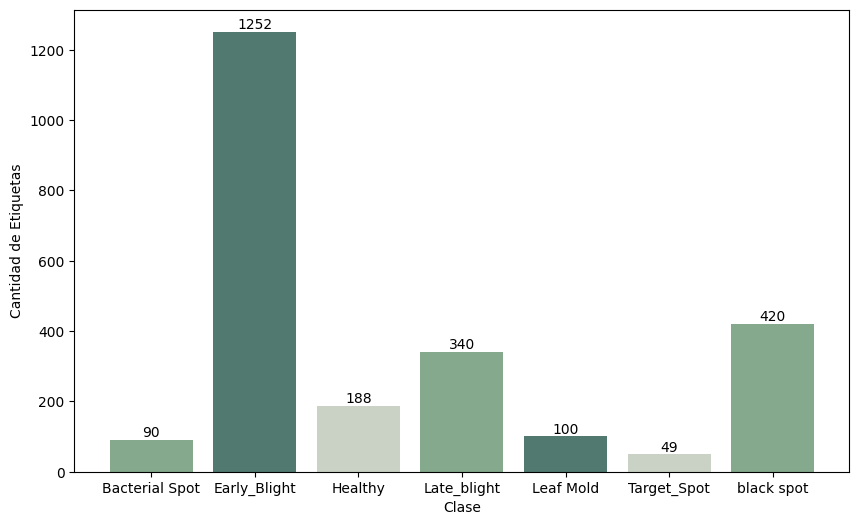

In [16]:
# gráficar la distribución de clases general del dataset 
plot_class_distribution(labels_count)

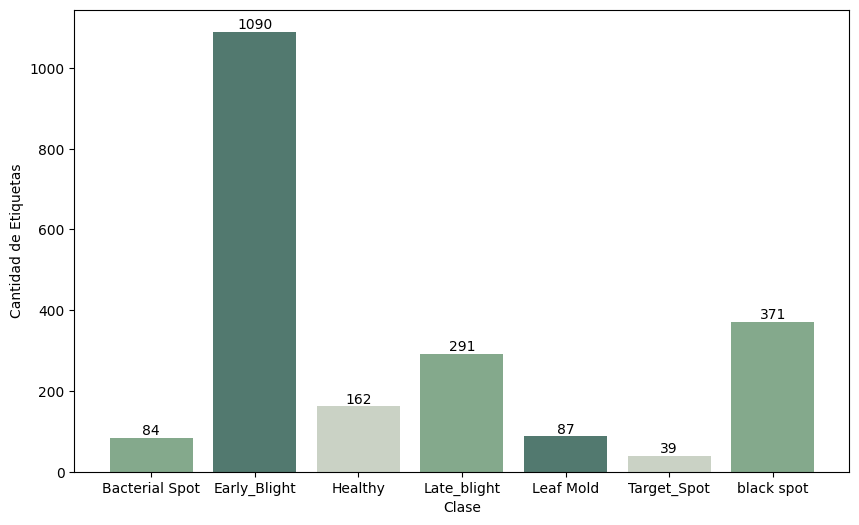

In [17]:
# contar la frecuencia de cada etiqueta en los labels de prueba, ordena los valores por clase
labels_train_count = pd.Series(train_labels).value_counts().sort_index()
# reemplazar los índices de las etiquetas numéricas por los nombres de las clases correspondientes
labels_train_count.index = [class_names[i] for i in labels_train_count.index]

# gráficar la distribución de etiquetas en los datos de entrenamiento
plot_class_distribution(labels_train_count)

### <font face = "Century Gothic">**Análisis de Calidad de Imágenes**</font>

In [18]:
def check_image_resolution(image_path):
    """
    Verifica la resolución de la imagen dada

    Parámetros:
    - image_path (str): Ruta de la imagen

    Retorna:
    - (tuple): Ancho y alto de la imagen
    """
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

In [19]:
def check_image_sharpness(image_path):
    """
    Evalúa la nitidez de la imagen comparándola con una versión desenfocada

    Parámetros:
    - image_path (str): Ruta de la imagen

    Retorna:
    - (bool): True si la imagen es nítida, False en caso contrario
    """
    with Image.open(image_path) as img:
        blurred = img.filter(ImageFilter.BLUR)
        diff = ImageChops.difference(img, blurred)
        return diff.getbbox() is not None

In [20]:
def calculate_noise(image_path):
    """
    Estima el nivel de ruido en una imagen comparando 
    la imagen original con una versión suavizada por 
    filtro de mediana
    
    Parámetros:
    - image_path (str): Ruta de la imagen.
    
    Retorna:
    - (float): Valor que representa el nivel de ruido en la imagen
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    median_blurred = cv2.medianBlur(img, 3)
    noise = cv2.absdiff(img, median_blurred)
    noise_level = np.mean(noise)
    
    return noise_level

In [21]:
def check_image_format(image_path):
    """
    Verifica si el formato de la imagen es válido y adecuado para su uso en análisis

    Parámetros:
    - image_path (str): Ruta de la imagen

    Retorna:
    - (str): Formato de la imagen (ej. 'JPEG', 'PNG')
    """
    with Image.open(image_path) as img:
        return img.format

In [22]:
def plot_color_histogram(image_path):
    """
    Muestra el histograma de color de una imagen, lo que permite 
    visualizar la distribución de colores

    Parámetros:
    - image_path (str): Ruta de la imagen

    Muestra:
    - Gráfico de histograma de los canales de color
    """
    img = cv2.imread(image_path)
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.show()

In [23]:
def analyze_image_quality(image_dir):
    """
    Analiza la calidad de las imágenes en una carpeta, evaluando la resolución, nitidez, 
    ruido y mostrando el histograma de color

    Parámetros:
    - image_dir (str): Directorio que contiene las imágenes

    Retorna:
    - No retorna, pero imprime los resultados de la evaluación de calidad
    """
    total_images = 0
    valid_images = 0
    
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                total_images += 1
                image_path = os.path.join(root, file)
                
                try:
                    # verificar la resolución
                    width, height = check_image_resolution(image_path)
                    print(f"Resolución de {file}: {width}x{height}")
                
                    # verificar la nitidez
                    sharpness = check_image_sharpness(image_path)
                    print(f"¿Imagen {file} nítida? {'Sí' if sharpness else 'No'}")
                
                    # calcular nivel de ruido
                    noise_level = calculate_noise(image_path)
                    print(f"Nivel estimado de ruido en {file}: {noise_level}")

                    # verificar el formato de la imagen 
                    image_format = check_image_format(image_path)
                    print(f"Formato de imagen {file}: {image_format}")

                    # mostrar el histograma de color
                    plot_color_histogram(image_path)

                    valid_images += 1 

                except Exception as e:
                    print(f"Error analizando {file}: {e}")   
    print(f"\nTotal de imágenes analizadas: {total_images}")
    print(f"Imágenes válidas: {valid_images}")

In [ ]:
print("Analizando conjunto de entrenamiento:")
analyze_image_quality(train_path)

### <font face = "Century Gothic">**Etiquetado de Clases**</font>

In [24]:
def load_image(path):
    """
    Carga y convierte una imagen de un archivo

    Args:
        path (str): Ruta de la imagen a cargar

    Returns:
        numpy.ndarray: Imagen cargada en formato RGB

    Funcionalidad:
        - Lee la imagen desde el archivo especificado
        - Convierte la imagen de formato BGR (por defecto en OpenCV) a RGB
    """
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [25]:
def load_labels_with_image_paths(images_path, labels_path):
    """
    Carga imágenes y etiquetas desde las rutas especificadas

    Args:
        images_path (Path): Ruta al directorio de imágenes
        labels_path (Path): Ruta al directorio de archivos de etiquetas (archivos .txt)

    Returns:
        tuple: Una lista de rutas de imágenes y una lista de etiquetas correspondientes
    
    Funcionalidad:
        - Recorre todos los archivos de texto (etiquetas) en el directorio de etiquetas
        - Para cada archivo de etiquetas, se leen las líneas y se guardan como listas de valores flotantes
        - Asocia cada archivo de etiquetas con una imagen correspondiente basada en el nombre de archivo 
        - Devuelve las rutas de las imágenes y las etiquetas asociadas
    """
    images, labels = [], []
    for label_file in Path(labels_path).glob('*.txt'):
        with open(label_file, 'r') as file:
            label_lines = file.readlines()
        if label_lines:
            # obtener la ruta de la imagen correspondiente al archivo de etiqueta
            img_path = images_path / (label_file.stem + '.jpg')
            images.append(str(img_path))
            # convertir cada línea del archivo de etiquetas en una lista de valores flotantes
            labels.append([list(map(float, line.split())) for line in label_lines])
    return images, labels

In [26]:
# cargr las imágenes y etiquetas, sustituyendo 'images' por 'labels' en la ruta para obtener las etiquetas correspondientes
train_images, train_labels = load_labels_with_image_paths(Path(train_path), Path(train_path.replace('images', 'labels')))
val_images, val_labels = load_labels_with_image_paths(Path(val_path), Path(val_path.replace('images', 'labels')))
test_images, test_labels = load_labels_with_image_paths(Path(test_path), Path(test_path.replace('images', 'labels')))

In [27]:
def plot_image_with_boxes(img_path, labels, class_names):
    """
    Dibuja una imagen con sus correspondientes cuadros delimitadores (bounding boxes) y nombres de clases

    Args:
        img_path (str): Ruta de la imagen que se va a cargar y mostrar
        labels (list): Lista de etiquetas asociadas a la imagen, donde cada etiqueta contiene:
                       [índice de clase, coordenada x, coordenada y, ancho del cuadro, altura del cuadro]
        class_names (list): Lista con los nombres de las clases, mapeadas por su índice

    Funcionalidad:
        - Carga la imagen desde la ruta proporcionada
        - Ajusta las coordenadas de las cajas delimitadoras en proporción a las dimensiones de la imagen
        - Dibuja los cuadros delimitadores alrededor de los objetos detectados
        - Escribe el nombre de la clase encima de cada cuadro delimitador
        - Muestra la imagen con las cajas y etiquetas utilizando matplotlib, desactivando los ejes
    """
    img = load_image(img_path)  # cargar la imagen
    h, w, _ = img.shape  # obtener las dimensiones de la imagen
    
    # para cada etiqueta (clase y coordenadas de la caja), dibujar los cuadros y nombres
    for label in labels:
        class_idx, x, y, box_w, box_h = label
        box_w, box_h = int(box_w * w), int(box_h * h)  # escalar el ancho y alto de la caja según la imagen
        x, y = int(x * w - box_w / 2), int(y * h - box_h / 2)  # calcular la posición de la caja en la imagen
        # dibujar el cuadro delimitador en la imagen
        img = cv2.rectangle(img, (x, y), (x + box_w, y + box_h), (255, 0, 0), 2)
        # escribir el nombre de la clase en la imagen
        img = cv2.putText(img, class_names[int(class_idx)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (239, 13, 23), 2)
    
    # mostrar la imagen con los cuadros delimitadores y etiquetas
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # convertir la imagen a formato RGB para mostrar correctamente
    plt.axis('off')  # desactivar los ejes de la imagen
    plt.show()  # mostrar la imagen

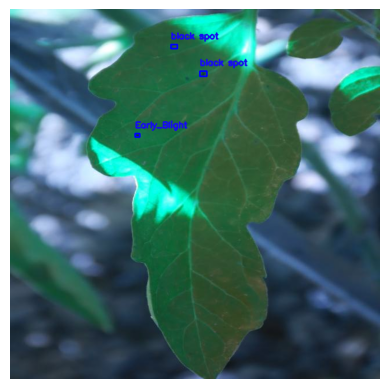

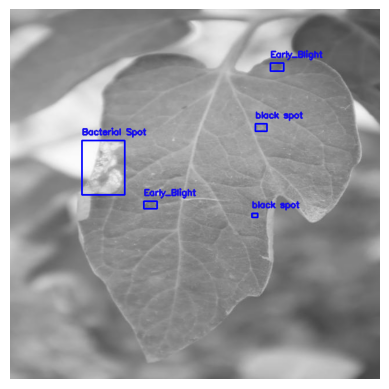

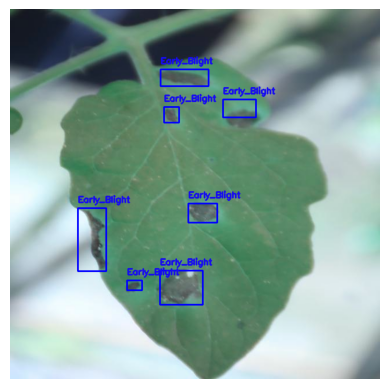

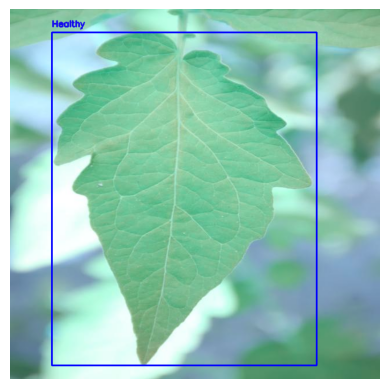

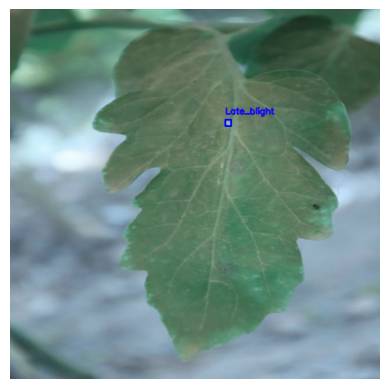

In [28]:
# recorrer las imágenes y etiquetas de entrenamiento entre las posiciones 20 y 30
for img, lbl in zip(train_images[35:40], train_labels[35:40]):
    # llamar a la función para dibujar cada imagen con sus respectivos cuadros delimitadores y nombres de clase
    plot_image_with_boxes(img, lbl, class_names)

## <font face = "Century Gothic">**Entrenamiento del Modelo de ML - YOLO**</font>

### <font face = "Century Gothic">**YOLOv10-N**</font>

<font face = "Century Gothic" size="3"> YOLOv10-N es una variante del modelo YOLO (You Only Look Once), una arquitectura popular para la detección de objetos en tiempo real. En su versión "N" (Nano), está diseñado para ser aún más ligero y eficiente, optimizando tanto el rendimiento como el consumo de recursos. Este modelo se enfoca en dispositivos con capacidad de procesamiento limitada.</font>

##### <font face = "Century Gothic">**Entrenamiento del Modelo**</font>

<font face = "Century Gothic" size="3">El modelo se entrena utilizando el conjunto de entrenamiento, donde aprende a ajustar sus parámetros (pesos) para minimizar el error de predicción en las imágenes etiquetadas.</font>

In [29]:
# verificar si una GPU compatible con CUDA está disponible
# si es así, se usa 'cuda' como dispositivo para realizar los cálculos en la GPU.
# si no hay GPU disponible, se utiliza 'cpu' para que los cálculos se realicen en el procesador.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
# cargar el modelo YOLOv10 preentrenado desde el archivo 'yolov10n.pt'
# '.to(device)' mueve el modelo al dispositivo seleccionado (GPU o CPU) según se haya definido anteriormente
model = YOLO('yolov10n.pt').to(device)

<ul>
    <li><p><font face = "Century Gothic" size ="3"><b>¿Qué es una capa de un modelo de red neuronal?:</b> Una capa (<code>name</code>) es como un filtro que toma los datos de entrada y los procesa para extraer información útil. Cada capa realiza una operación sobre los datos, y sus resultados se pasan a la siguiente capa, permitiendo que el modelo refine cada vez más los detalles de la entrada.</font></p></li>
    <li><p><font face = "Century Gothic" size ="3"><b>¿Qué son los pesos?:</b> Los pesos (<code>param.shape</code>) son los parámetros ajustables de cada filtro (capa). Determinan qué tanto afecta el filtro a los datos. Durante el entrenamiento, el modelo ajusta los pesos para optimizar las predicciones.</font></p></li>
    <li><p><font face = "Century Gothic" size ="3"><b>Capa Convolucional</b>  (<code>conv</code>): Una capa convolucional es un tipo de filtro usado en redes neuronales que procesan imágenes. Captura características como bordes o texturas al aplicar pequeños filtros (ej. 3x3) sobre las imágenes de entrada, generando características más complejas a medida que avanza en las capas.</font></p></li>
    <li><p><font face = "Century Gothic" size ="3"><b>Normalización por lotes</b> (<code>batch normalization - bn</code>): Después de aplicar un filtro convolucional, se ajustan los valores mediante normalización por lotes, lo que ayuda a que los datos pasen uniformemente entre las capas y estabiliza el entrenamiento.</font></p></li>
    <li><p><font face = "Century Gothic" size ="3"><b>Capas de atención</b> (<code>attention layers - attn</code>): Las capas de atención permiten que el modelo se concentre en las partes más relevantes de los datos, ayudando a mejorar la precisión de las predicciones.</font></p></li>
    <li><b>Total de Capas</b>:
        <ul>
        <li> 82 capas convolucionales <code>.conv</code> </li>
        <li> 49 capas de normalización por lotes <code>.bn</code></li>
        </ul>
    </li>
  </ul>


In [31]:
# acceder a los pesos del modelo YOLOv10-N
for name, param in model.named_parameters():
    print(f"Capa: {name}, Peso: {param.shape}")

Capa: model.model.0.conv.weight, Peso: torch.Size([16, 3, 3, 3])
Capa: model.model.0.bn.weight, Peso: torch.Size([16])
Capa: model.model.0.bn.bias, Peso: torch.Size([16])
Capa: model.model.1.conv.weight, Peso: torch.Size([32, 16, 3, 3])
Capa: model.model.1.bn.weight, Peso: torch.Size([32])
Capa: model.model.1.bn.bias, Peso: torch.Size([32])
Capa: model.model.2.cv1.conv.weight, Peso: torch.Size([32, 32, 1, 1])
Capa: model.model.2.cv1.bn.weight, Peso: torch.Size([32])
Capa: model.model.2.cv1.bn.bias, Peso: torch.Size([32])
Capa: model.model.2.cv2.conv.weight, Peso: torch.Size([32, 48, 1, 1])
Capa: model.model.2.cv2.bn.weight, Peso: torch.Size([32])
Capa: model.model.2.cv2.bn.bias, Peso: torch.Size([32])
Capa: model.model.2.m.0.cv1.conv.weight, Peso: torch.Size([16, 16, 3, 3])
Capa: model.model.2.m.0.cv1.bn.weight, Peso: torch.Size([16])
Capa: model.model.2.m.0.cv1.bn.bias, Peso: torch.Size([16])
Capa: model.model.2.m.0.cv2.conv.weight, Peso: torch.Size([16, 16, 3, 3])
Capa: model.model.2

In [32]:
# listar todas las capas del modelo para ver cada capa de modelo, su tipo 
# y sus parámetros
for name, layer in model.named_modules():
    print(f"Capa: {name} -> {layer}")

Capa:  -> YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track

In [33]:
# entrenar el modelo utilizando los parámetros especificados:
# - data=data_yaml_path: fefine la ruta al archivo YAML que contiene la configuración del conjunto de datos (clases, ubicaciones de imágenes y etiquetas)
# - epochs=100: establece el número de iteraciones completas sobre el conjunto de datos de entrenamiento) a 100
# - imgsz=640: especifica el tamaño de las imágenes de entrada al modelo, redimensionando cada imagen a 640x640 píxeles
# - batch=16: define el tamaño del batch (lote) en 16, lo que significa que el modelo procesará 16 imágenes a la vez antes de actualizar los pesos
model.train(data=data_yaml_path, epochs=100, imgsz=640, batch=16)

engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=tomato_diseases_detection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=F

 23        [16, 19, 22]  1    864058  ultralytics.nn.modules.head.v10Detect        [7, [64, 128, 256]]           
YOLOv10n summary: 385 layers, 2,709,770 parameters, 2,709,754 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /home/paperspace/tomatoe/cata-folder/cata-folder/tomato_diseases_detection/datasets/train/labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]
val: Scanning /home/paperspace/tomatoe/cata-folder/cata-folder/tomato_diseases_detection/datasets/valid/labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train10
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       3.1G      3.178      9.225      2.399         25        640: 100%|██████████| 41/41 [00:08<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         61        196    0.00896      0.213     0.0616     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.12G      3.086      6.931      2.374         28        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         61        196      0.919     0.0677       0.11     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.13G      3.163       6.26      2.319         14        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         61        196      0.821      0.095      0.152     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.11G      3.111      5.826       2.34         24        640: 100%|██████████| 41/41 [00:05<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         61        196      0.544      0.287      0.273       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.11G      2.983      5.542      2.354         15        640: 100%|██████████| 41/41 [00:05<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         61        196      0.752      0.256      0.304      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.12G      2.987      5.121      2.329         17        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         61        196      0.828      0.227      0.289      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.13G       2.93      4.654      2.271         21        640: 100%|██████████| 41/41 [00:05<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         61        196      0.837      0.276      0.302      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.11G      2.982      4.402      2.316         17        640: 100%|██████████| 41/41 [00:05<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         61        196      0.779      0.316       0.33       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.18G       2.94      4.013      2.235         20        640: 100%|██████████| 41/41 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         61        196      0.606      0.378      0.335      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.13G      2.829      3.699      2.209         38        640: 100%|██████████| 41/41 [00:05<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         61        196      0.407      0.418      0.314        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.12G      2.763      3.497      2.174         21        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         61        196      0.462      0.505      0.415       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.15G      2.785      3.485      2.168         26        640: 100%|██████████| 41/41 [00:05<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         61        196      0.668      0.385      0.401      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.12G       2.82      3.294      2.196         25        640: 100%|██████████| 41/41 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         61        196      0.447      0.451      0.427       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.12G      2.738      3.108      2.167         16        640: 100%|██████████| 41/41 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         61        196      0.505      0.446      0.468      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.1G      2.741      3.045      2.162         13        640: 100%|██████████| 41/41 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         61        196      0.535       0.42      0.464      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       3.1G      2.642      2.881      2.118         22        640: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         61        196      0.469      0.446      0.483       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.12G      2.647      2.807       2.15         19        640: 100%|██████████| 41/41 [00:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         61        196      0.444      0.577       0.49      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       3.1G      2.709      2.706      2.165         31        640: 100%|██████████| 41/41 [00:05<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         61        196      0.536       0.56      0.516      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.13G       2.71      2.628      2.121         21        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         61        196      0.552      0.603      0.562      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.11G      2.591      2.593      2.129         27        640: 100%|██████████| 41/41 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         61        196      0.479      0.578      0.479       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.12G      2.653      2.473      2.097         28        640: 100%|██████████| 41/41 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         61        196      0.414      0.557      0.491      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.12G      2.618      2.366      2.105         12        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         61        196      0.647      0.575       0.58      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.12G      2.524       2.37      2.074         22        640: 100%|██████████| 41/41 [00:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         61        196      0.482      0.583      0.548      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.09G       2.59       2.37      2.103         18        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         61        196      0.469       0.64      0.529      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.13G      2.504      2.217      2.043         26        640: 100%|██████████| 41/41 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         61        196      0.494      0.503      0.511      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.12G      2.493      2.222      2.067         42        640: 100%|██████████| 41/41 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         61        196      0.493      0.522      0.509      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.11G       2.51      2.242       2.08         21        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         61        196      0.642      0.512      0.541      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.12G        2.5      2.202       2.06         10        640: 100%|██████████| 41/41 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         61        196      0.495       0.63      0.577      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.17G      2.538      2.131      2.066         20        640: 100%|██████████| 41/41 [00:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         61        196      0.763       0.52      0.609      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.1G      2.466      2.093       2.05         29        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         61        196      0.613      0.636      0.626      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.12G      2.474      2.072      2.019         30        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         61        196      0.671      0.507      0.598      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.17G      2.465      2.023      2.038         24        640: 100%|██████████| 41/41 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         61        196      0.715      0.509      0.591       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.12G      2.444      2.003      2.045         33        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         61        196      0.734      0.567      0.618      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.18G      2.323      1.907      2.013         13        640: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         61        196      0.686      0.633      0.654      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.12G      2.374      1.861      2.022         19        640: 100%|██████████| 41/41 [00:05<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         61        196       0.63      0.642      0.627      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.15G      2.367      1.848       2.03         11        640: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         61        196      0.661      0.606      0.656      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.1G      2.299      1.796      1.998         12        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         61        196      0.638      0.563      0.605      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.12G      2.275      1.835      1.992         31        640: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         61        196      0.739      0.594      0.659      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.12G      2.306      1.811      2.005         16        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         61        196      0.666      0.608      0.675      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.09G      2.372      1.842      1.994         17        640: 100%|██████████| 41/41 [00:05<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         61        196      0.615      0.623       0.64      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.13G      2.268      1.763      1.974         12        640: 100%|██████████| 41/41 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         61        196      0.604      0.662      0.629      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.12G      2.199      1.646       1.97         20        640: 100%|██████████| 41/41 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         61        196      0.635      0.615      0.634      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       3.1G      2.262       1.69      1.976         15        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         61        196      0.653      0.607      0.642      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.12G      2.315      1.696      1.991         25        640: 100%|██████████| 41/41 [00:05<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         61        196      0.631      0.637      0.644       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       3.1G      2.321      1.733      1.967         20        640: 100%|██████████| 41/41 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         61        196      0.682      0.671      0.663      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.16G      2.166      1.611      1.952         24        640: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         61        196      0.702      0.706      0.676      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.11G      2.248       1.71      1.978         37        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         61        196       0.59      0.749        0.7      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.15G      2.292      1.733      1.981         14        640: 100%|██████████| 41/41 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         61        196      0.649      0.702      0.682      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.1G      2.236      1.662      1.972         28        640: 100%|██████████| 41/41 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         61        196      0.741      0.691      0.711      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       3.1G      2.222      1.652      1.964         19        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         61        196      0.743      0.588      0.666      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.16G        2.2      1.625      1.939         34        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         61        196      0.636      0.701      0.657      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.12G      2.178      1.576      1.955         25        640: 100%|██████████| 41/41 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         61        196      0.658       0.66       0.63      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.12G      2.115      1.559      1.912         21        640: 100%|██████████| 41/41 [00:05<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         61        196      0.675      0.717       0.65      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.13G      2.095      1.538      1.917         24        640: 100%|██████████| 41/41 [00:05<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         61        196      0.698       0.69      0.672      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.12G      2.117      1.514      1.935         30        640: 100%|██████████| 41/41 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         61        196      0.679      0.682      0.668      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.12G      2.149      1.539      1.928         24        640: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         61        196      0.617      0.697      0.653      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       3.1G      2.117      1.493      1.926         14        640: 100%|██████████| 41/41 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         61        196      0.683      0.661      0.688       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.13G      2.056      1.451       1.89         31        640: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         61        196      0.705      0.603      0.646      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.12G      2.092      1.466      1.911         21        640: 100%|██████████| 41/41 [00:05<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         61        196      0.663      0.682      0.684      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.11G       2.05      1.497      1.898         48        640: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         61        196       0.65      0.721      0.671       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.1G      2.055      1.519       1.91         28        640: 100%|██████████| 41/41 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         61        196      0.776      0.648       0.71      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.12G      2.134      1.531        1.9         38        640: 100%|██████████| 41/41 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         61        196      0.693      0.701      0.701      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.16G      2.071      1.502      1.917          7        640: 100%|██████████| 41/41 [00:06<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         61        196      0.692      0.698      0.672      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.09G      2.054      1.479      1.897         19        640: 100%|██████████| 41/41 [00:05<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         61        196      0.669      0.732       0.67      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.13G      2.025      1.436      1.902         28        640: 100%|██████████| 41/41 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         61        196      0.648      0.761      0.686      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.12G      2.061      1.487      1.915         39        640: 100%|██████████| 41/41 [00:05<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         61        196      0.664      0.793      0.705      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.1G      2.136      1.468      1.903         49        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         61        196      0.675      0.692      0.686      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.12G      2.038      1.451      1.889         22        640: 100%|██████████| 41/41 [00:05<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         61        196      0.642      0.699      0.661      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.13G      2.031       1.41      1.894         16        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         61        196      0.748      0.646      0.708      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.12G      2.032      1.409      1.904         17        640: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         61        196      0.627      0.681       0.66      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.13G      1.889        1.3      1.842         31        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         61        196      0.667      0.676      0.682      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.16G      1.985      1.368      1.881         27        640: 100%|██████████| 41/41 [00:05<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         61        196      0.728      0.668      0.685      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.12G      1.929      1.327      1.891         38        640: 100%|██████████| 41/41 [00:05<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         61        196        0.7      0.675      0.698      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.12G      1.935      1.316      1.851         23        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         61        196      0.619      0.731      0.712      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.14G      1.919      1.347      1.877         27        640: 100%|██████████| 41/41 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         61        196      0.674      0.664       0.68      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.12G      1.915      1.264       1.87         17        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         61        196      0.763      0.733       0.74      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.12G      1.881       1.34      1.866         25        640: 100%|██████████| 41/41 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         61        196       0.64      0.735      0.704      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.1G      1.884       1.31      1.872         18        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         61        196      0.613      0.721      0.693      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.12G      1.846      1.295       1.85         27        640: 100%|██████████| 41/41 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         61        196      0.709      0.652      0.684      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.12G      1.897      1.248      1.852         14        640: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         61        196      0.751      0.638      0.699       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.17G      1.823      1.251      1.849         29        640: 100%|██████████| 41/41 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         61        196       0.66      0.683      0.677      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.11G      1.799      1.221      1.853         24        640: 100%|██████████| 41/41 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         61        196      0.661       0.73      0.689      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.12G      1.879      1.271      1.867         30        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         61        196      0.649      0.692      0.673      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.1G      1.771      1.195      1.812         25        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         61        196       0.62       0.68      0.652      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.12G      1.843      1.259      1.834         22        640: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         61        196       0.67       0.71      0.697       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.13G      1.869      1.263      1.843         22        640: 100%|██████████| 41/41 [00:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         61        196      0.707      0.714      0.706      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.18G      1.867      1.259      1.857         15        640: 100%|██████████| 41/41 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         61        196      0.641      0.748      0.689       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.08G      1.853      1.223      1.826         15        640: 100%|██████████| 41/41 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         61        196      0.632      0.746      0.681       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.14G      1.806      1.227      1.833         32        640: 100%|██████████| 41/41 [00:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         61        196       0.66      0.728      0.687      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.13G      1.773      1.184      1.812         10        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         61        196      0.709      0.725      0.705      0.459


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.12G      1.906      1.247      1.799         12        640: 100%|██████████| 41/41 [00:06<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         61        196       0.72      0.727      0.707      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.11G      1.877      1.258       1.81         29        640: 100%|██████████| 41/41 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         61        196      0.685      0.732      0.711      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.13G      1.879      1.204      1.806         11        640: 100%|██████████| 41/41 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         61        196      0.646      0.753      0.699      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       3.1G      1.879       1.25      1.803         25        640: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         61        196      0.747      0.716      0.735      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.12G      1.833      1.175      1.779         18        640: 100%|██████████| 41/41 [00:05<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         61        196       0.72       0.76      0.714      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.08G      1.816      1.231      1.771          9        640: 100%|██████████| 41/41 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         61        196      0.764      0.742      0.736      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.13G      1.825      1.162      1.785         17        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         61        196      0.735      0.735      0.717      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.09G      1.817      1.172      1.779         25        640: 100%|██████████| 41/41 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         61        196      0.705      0.746      0.699      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.1G      1.834      1.197      1.789         16        640: 100%|██████████| 41/41 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         61        196       0.73      0.743      0.722      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.08G      1.781      1.139      1.777         16        640: 100%|██████████| 41/41 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         61        196      0.721      0.743      0.731      0.479



100 epochs completed in 0.194 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 5.8MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.5.0+cu124 CUDA:0 (Quadro RTX 5000, 16117MiB)
YOLOv10n summary (fused): 285 layers, 2,697,146 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


                   all         61        196      0.764      0.736       0.74      0.481
        Bacterial Spot          3          4      0.705      0.616      0.625      0.349
          Early_Blight         31         96      0.652      0.906       0.79      0.449
               Healthy         19         19      0.962          1      0.995      0.949
           Late_blight         13         29      0.692      0.828      0.843       0.66
             Leaf Mold          4          7      0.816      0.429      0.503       0.25
           Target_Spot          5          6      0.734      0.833      0.845      0.468
            black spot         21         35      0.791       0.54       0.58      0.245
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f144d4ac9d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [35]:
# evaluar el rendimiento del modelo en el conjunto de datos de validación
model.val(data = data_yaml_path, imgsz = 640, batch = 16)

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.5.0+cu124 CUDA:0 (Quadro RTX 5000, 16117MiB)


val: Scanning /home/paperspace/tomatoe/cata-folder/cata-folder/tomato_diseases_detection/datasets/valid/labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


                   all         61        196      0.766      0.734       0.74      0.478
        Bacterial Spot          3          4      0.703      0.609      0.625      0.349
          Early_Blight         31         96      0.652      0.906       0.79      0.451
               Healthy         19         19      0.962          1      0.995      0.949
           Late_blight         13         29      0.703      0.828      0.843      0.657
             Leaf Mold          4          7      0.822      0.429      0.503      0.228
           Target_Spot          5          6      0.734      0.833      0.845      0.469
            black spot         21         35      0.789      0.535      0.579      0.244
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train102


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f15a4667f70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  


0: 640x640 1 Late_blight, 12.1ms
Speed: 18.7ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


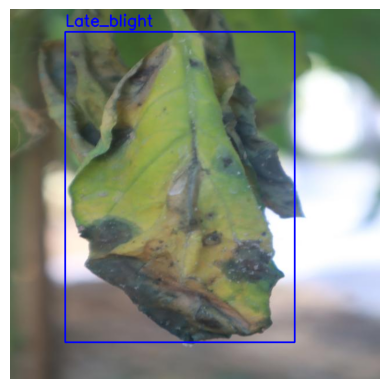


0: 640x640 7 Early_Blights, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


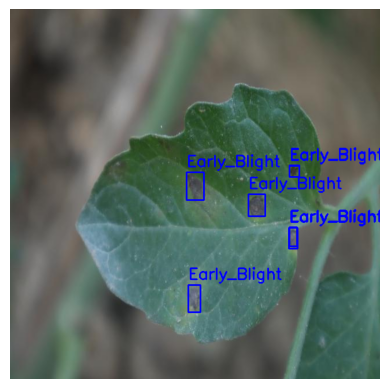


0: 640x640 1 Late_blight, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


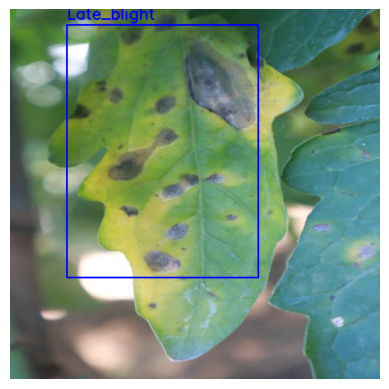


0: 640x640 1 Late_blight, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


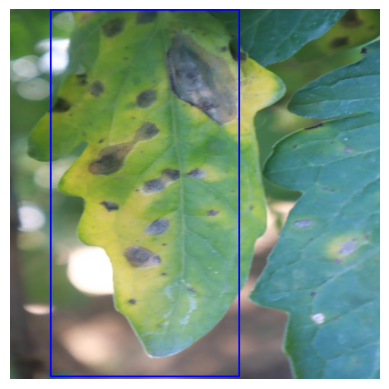


0: 640x640 1 Healthy, 1 Late_blight, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


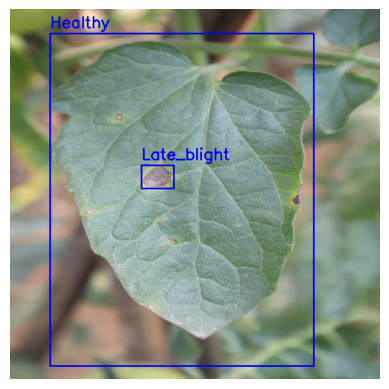


0: 640x640 1 Healthy, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


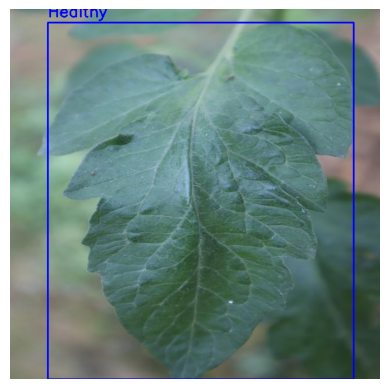


0: 640x640 1 Early_Blight, 2 black spots, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 2 Early_Blights, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


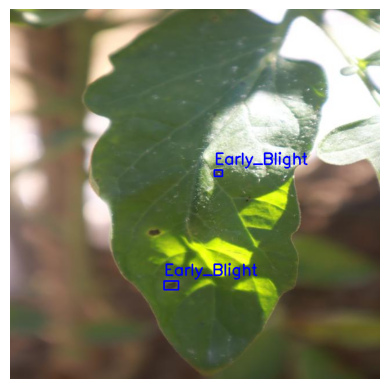


0: 640x640 1 Early_Blight, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


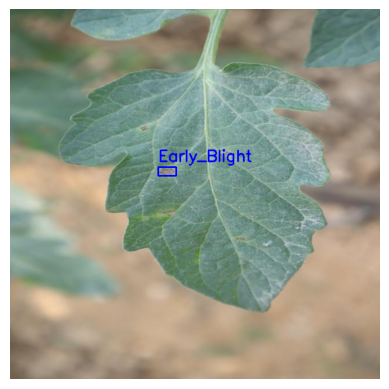


0: 640x640 1 Early_Blight, 1 Late_blight, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


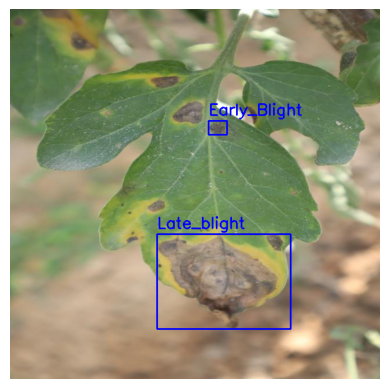


0: 640x640 1 Healthy, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


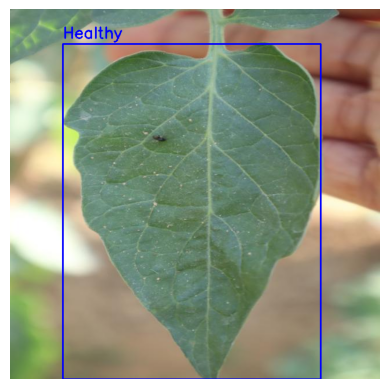


0: 640x640 1 Healthy, 13.9ms
Speed: 1.8ms preprocess, 13.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


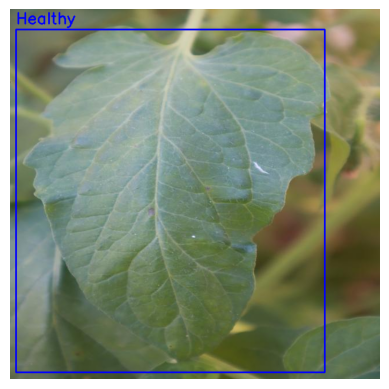


0: 640x640 11 Early_Blights, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 1 Early_Blight, 2 Late_blights, 10.7ms
Speed: 1.6ms preprocess, 10.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 5 Early_Blights, 1 Late_blight, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


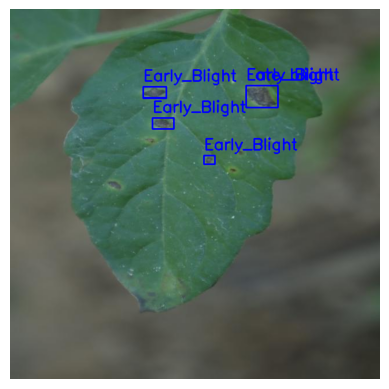


0: 640x640 1 Healthy, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


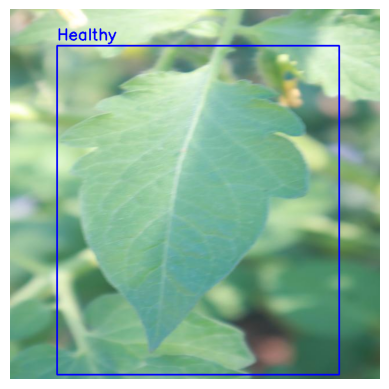


0: 640x640 1 Healthy, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


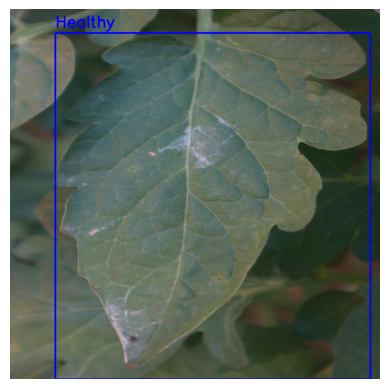


0: 640x640 3 Early_Blights, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


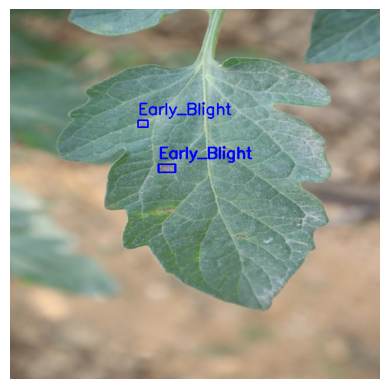


0: 640x640 2 Target_Spots, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


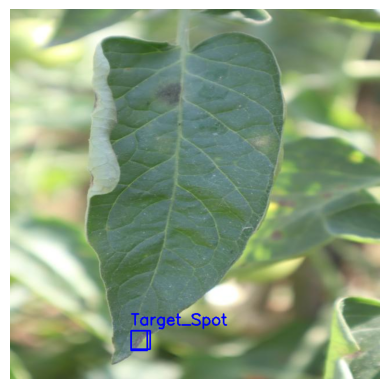


0: 640x640 1 Healthy, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 1 Early_Blight, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


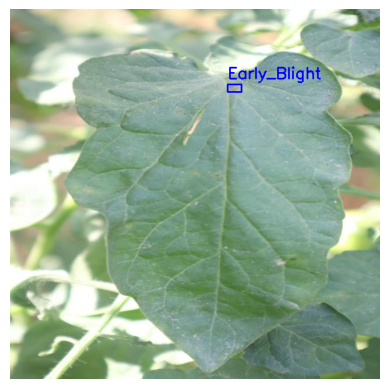


0: 640x640 1 Healthy, 11.1ms
Speed: 1.7ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 1 Healthy, 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 1 Target_Spot, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 5 Early_Blights, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


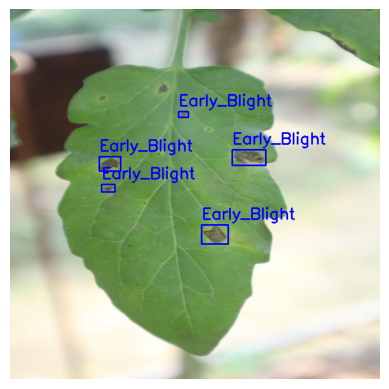


0: 640x640 6 Early_Blights, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


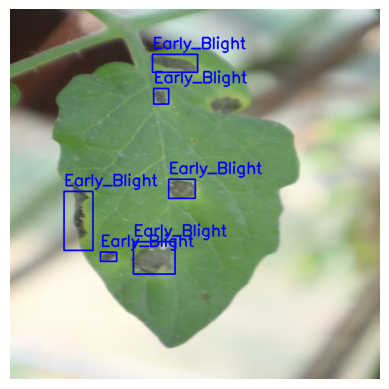


0: 640x640 1 Healthy, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


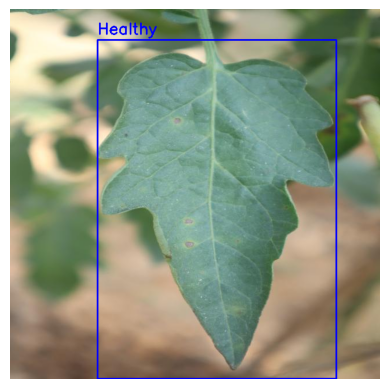


0: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


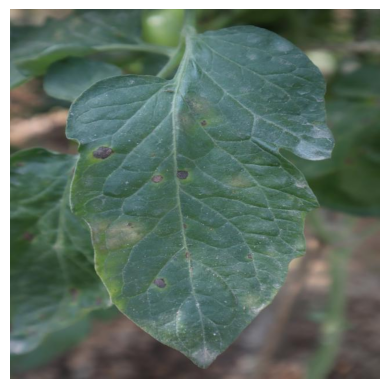


0: 640x640 (no detections), 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


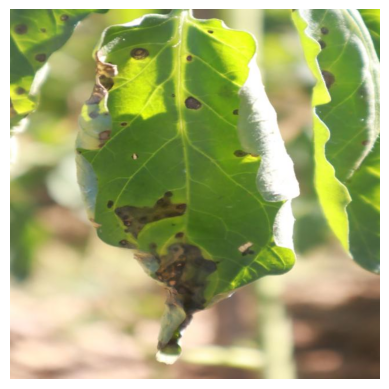


0: 640x640 5 Early_Blights, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


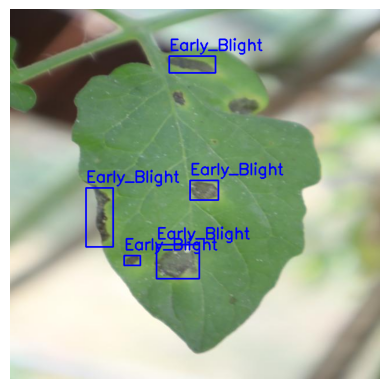


0: 640x640 1 Early_Blight, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


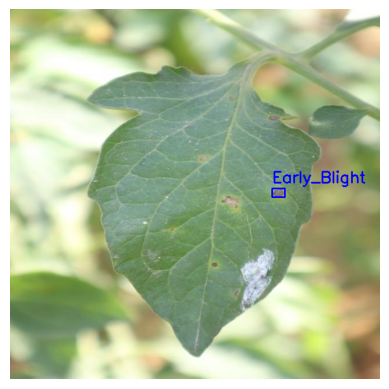

In [36]:
def plot_image_with_detected_boxes(img_path, model):

    img = load_image(img_path)  # cargar la imagen desde la ruta dada
    results = model.predict(source=img, save=False)  # predicir los cuadros y clases con el modelo
    for result in results:
        boxes = result.boxes.xyxy  # obtener las coordenadas de las cajas en formato [x1, y1, x2, y2]
        classes = result.boxes.cls  # obtener las clases detectadas para cada cuadro
        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, box)  # convertir las coordenadas de las cajas a enteros
            # dibujar un cuadro delimitador (rectángulo) en la imagen
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            # colocar el nombre de la clase correspondiente sobre la caja delimitadora
            img = cv2.putText(img, class_names[int(cls)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    
    # mostrar la imagen con los cuadros delimitadores
    plt.imshow(img)
    plt.axis('off')  # desactivar los ejes en la visualización
    plt.show()
    return img  # devolver la imagen con los cuadros dibujados

# directorio donde se guardarán las imágenes procesadas
output_dir = 'tomato_diseases_detection/datasets/working'

# crear el directorio si no existe
os.makedirs(output_dir, exist_ok=True)

# iterar sobre las imágenes de prueba
for i, img_path in enumerate(test_images):
    # dibujar los cuadros detectados en la imagen y guarda el resultado
    img_with_boxes = plot_image_with_detected_boxes(img_path, model)
    output_path = os.path.join(output_dir, f'sample_{i}.jpg')  # definir la ruta de salida para guardar la imagen
    # guardar la imagen resultante con los cuadros en el directorio de salida
    cv2.imwrite(output_path, cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))